### Advanced Models
In this notebook, we examine additional NLP models beyond the naive BERT implementation. The models explored here (1) expand on BERT implementations not explored in the original paper and (2) draw on recent fake news detection publications to evaluate a CNN-LSTM approach for the GWSD dataset.


In [ ]:
!pip install pyyaml h5py
!pip install -q transformers
!pip install pydot --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from transformers import BertTokenizer, TFBertModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
NOTEBOOK_LOC = "/content/drive/MyDrive/Colab Notebooks/W266 Final Project/"

### Load Data

Also format data for weighted BERT below

In [ ]:
TRAIN_TEXTS = []
VALID_TEXTS = []

TRAIN_LABELS = []
VALID_LABELS = []

TRAIN_WEIGHTS = []

TARGET_NAMES = ["disagree", "neutral", "agree"]

CV_IDX = [0, 1, 2, 3, 4]

for cv_idx in CV_IDX:

  training_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_training_"+str(cv_idx)+".tsv")
  valid_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_val_"+str(cv_idx)+".tsv")


  train_texts = training_data["sentence"].to_list()
  train_labels = np.asarray(training_data["stance_id"].astype(int).to_list())

  valid_texts = valid_data["sentence"].to_list()
  valid_labels = np.asarray(valid_data["stance_id"].astype(int).to_list())

  training_data["weight"] = training_data[["agree", "neutral", "disagree"]].max(axis=1)
  train_weights = np.asarray(training_data["weight"]) # add label weights

  TRAIN_TEXTS.append(train_texts)
  VALID_TEXTS.append(valid_texts)

  TRAIN_LABELS.append(train_labels)
  VALID_LABELS.append(valid_labels)

  TRAIN_WEIGHTS.append(train_weights)

test_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_test.tsv")
test_texts = test_data["sentence"].to_list()
test_labels = np.asarray(test_data["stance_id"].astype(int).to_list())

### BERT Setup

In [ ]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

max_length = 256

TRAIN_ENCODINGS = []
VALID_ENCODINGS = []
TEST_ENCODINGS = []

for cv_idx in CV_IDX:

  train_encodings = bert_tokenizer(train_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
  valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
  test_encodings = bert_tokenizer(test_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')

  TRAIN_ENCODINGS.append(train_encodings)
  VALID_ENCODINGS.append(valid_encodings)
  TEST_ENCODINGS.append(test_encodings)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Fine-tuning weighted BERT with CNN
https://github.com/ZeroxTM/BERT-CNN-Fine-Tuning-For-Hate-Speech-Detection-in-Online-Social-Media
https://aclanthology.org/2020.semeval-1.271.pdf

In [ ]:
def create_weighted_bert_cnn_multiclass_model(hidden_size = 100, 
                                learning_rate=0.00005,
                                num_filters = [100, 100, 50, 25],
                                kernel_sizes = [3, 5, 10, 20],
                                dropout = 0.3):

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    h = bert_out[0][:,1:-1] # use the sequence output for cnn

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    h = keras.layers.Dropout(rate=dropout)(h)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(h)
    hidden = tf.keras.layers.Dropout(dropout)(hidden) 

    classification = tf.keras.layers.Dense(len(TARGET_NAMES), activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                            metrics='accuracy') 

    return classification_model


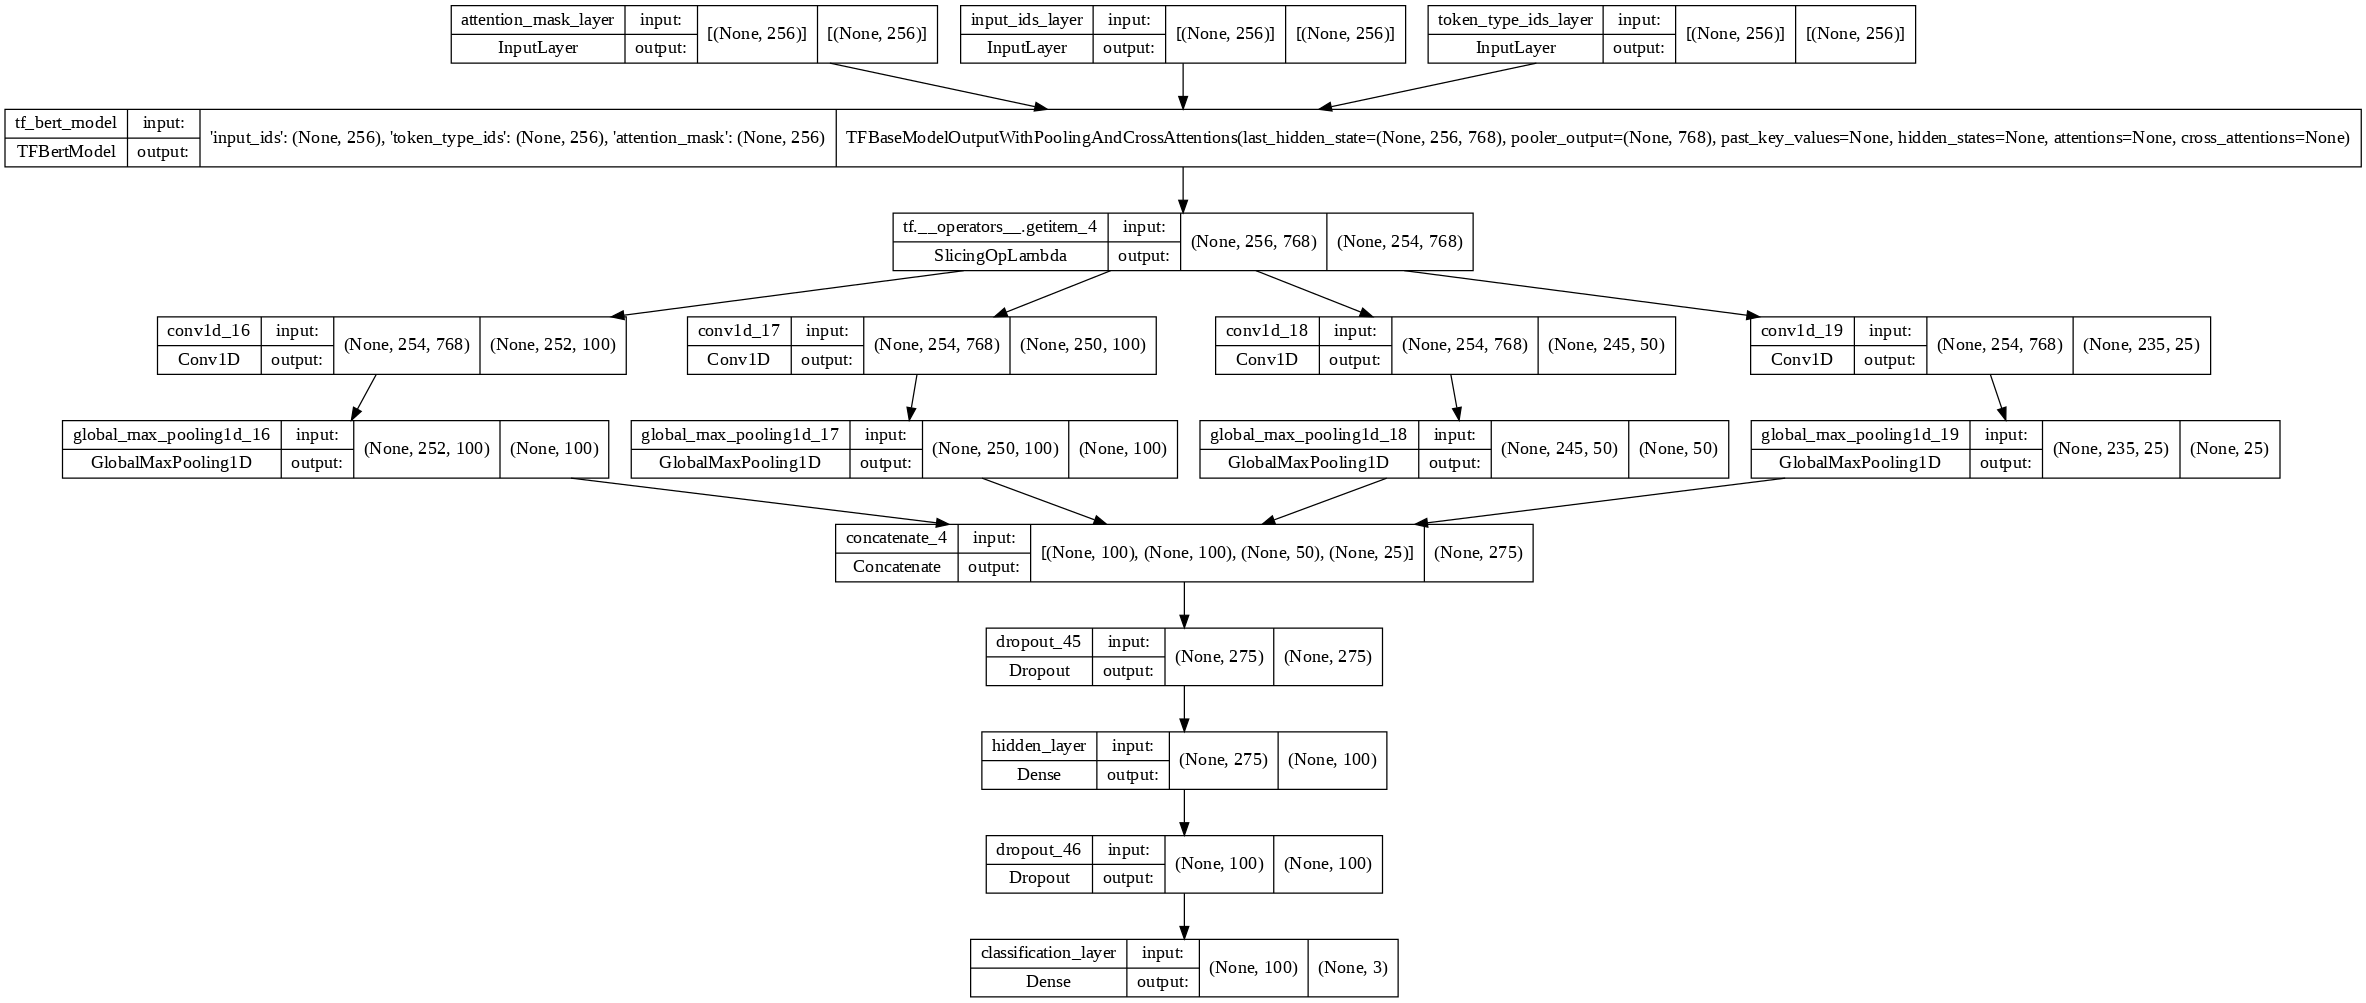

In [ ]:
model = create_weighted_bert_cnn_multiclass_model(hidden_size=100)
keras.utils.plot_model(model, show_shapes=True, dpi=90)


----------------------Training Cross Fold: 4----------------------
Epoch 1/7
93/93 [==============================] - 85s 680ms/step - loss: 0.9261 - accuracy: 0.4715 - val_loss: 0.8731 - val_accuracy: 0.6179
Epoch 2/7
93/93 [==============================] - 59s 640ms/step - loss: 0.6789 - accuracy: 0.6538 - val_loss: 0.8578 - val_accuracy: 0.6314
Epoch 3/7
93/93 [==============================] - 54s 580ms/step - loss: 0.4506 - accuracy: 0.7920 - val_loss: 0.9852 - val_accuracy: 0.5718
Epoch 4/7
93/93 [==============================] - 59s 640ms/step - loss: 0.2387 - accuracy: 0.8902 - val_loss: 1.2740 - val_accuracy: 0.6856
Epoch 5/7
93/93 [==============================] - 56s 601ms/step - loss: 0.1327 - accuracy: 0.9492 - val_loss: 1.2856 - val_accuracy: 0.6748
Epoch 6/7
93/93 [==============================] - 54s 578ms/step - loss: 0.0997 - accuracy: 0.9661 - val_loss: 1.5188 - val_accuracy: 0.6396
Epoch 7/7
93/93 [==============================] - 54s 580ms/step - loss: 0.1027 

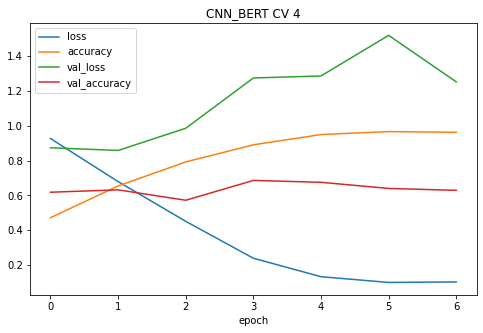

              precision    recall  f1-score   support

    disagree       0.65      0.51      0.57        39
     neutral       0.70      0.73      0.72        85
       agree       0.68      0.72      0.70        76

    accuracy                           0.69       200
   macro avg       0.68      0.66      0.66       200
weighted avg       0.68      0.69      0.68       200



In [ ]:
MODEL_NAME = "CNN_BERT"
EPOCHS = 7

for cv_idx in CV_IDX[4:]:

  model = create_weighted_bert_cnn_multiclass_model(hidden_size=100)

  print("----------------------Training Cross Fold: " + str(cv_idx) + "----------------------")

  checkpoint_filepath = 'Models/' + MODEL_NAME + str(cv_idx)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_freq='epoch',
      save_best_only=True)

  model_history = model.fit([TRAIN_ENCODINGS[cv_idx].input_ids, TRAIN_ENCODINGS[cv_idx].token_type_ids, TRAIN_ENCODINGS[cv_idx].attention_mask], 
                                                  TRAIN_LABELS[cv_idx],   
                                                  validation_data=([VALID_ENCODINGS[cv_idx].input_ids, VALID_ENCODINGS[cv_idx].token_type_ids, VALID_ENCODINGS[cv_idx].attention_mask], 
                                                  VALID_LABELS[cv_idx]),    
                                                  batch_size=16,  
                                                  callbacks=[model_checkpoint_callback],
                                                  epochs=EPOCHS,
                                                  sample_weight = TRAIN_WEIGHTS[cv_idx])
  
  pd.DataFrame(model_history.history).plot(figsize=(8,5))
  plt.title(MODEL_NAME+' CV ' + str(cv_idx))
  plt.xlabel('epoch')
  plt.savefig(NOTEBOOK_LOC + '/ModelResults/' + MODEL_NAME + str(cv_idx) + ".png")
  plt.show()
  
  model.load_weights(checkpoint_filepath)
  test_predictions = model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask]) 
  print(classification_report(test_labels, np.argmax(test_predictions, axis=1), target_names=TARGET_NAMES))

  np.save(NOTEBOOK_LOC + '/ModelResults/TestPredictions' + MODEL_NAME + str(cv_idx), test_predictions, allow_pickle=True)